# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import pandas as pd

C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

# num_test = len(newsgroups_test.target)
# test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
# dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
# train_data, train_labels = newsgroups_train.data, newsgroups_train.target

# print('training label shape:', train_labels.shape)
# print('test label shape:', test_labels.shape)
# print('dev label shape:', dev_labels.shape)
# print('labels names:', newsgroups_train.target_names)

num_test = round(len(newsgroups_test.target)/2)
test_data, test_labels = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
#def P1(num_examples=5):
### STUDENT START ###
for i in range(5):
    print("Label: {} {} \nText: \n {} ".format(train_labels[i], newsgroups_train.target_names[train_labels[i]], train_data[i])) # print label, category name, and text for first five training items
    print('_________________________________________________________________________')
### STUDENT END ###
#P1(2)

Label: 1 comp.graphics 
Text: 
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 
_________________________________________________________________________
Label: 3 talk.religion.misc 
Text: 
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [7]:
#def P2():
### STUDENT START ###

cv = CountVectorizer() # instantiate countvectorizer
fv = cv.fit_transform(train_data) # create feature vector using fit_transform

## a
print("Part A")
print("The size of the vocabulary is: {}".format(fv.shape[1])) # the number of columns is the the "vocabulary" the number of distinct words
print("The average number of non-zero features per example is {}".format(round(fv.nnz / fv.shape[0]),0)) # divide the number of nonzero features in the matrix by the number of training examples
print("{} percent of the entries in the matrix are non-zero".format(round(100 * fv.nnz/ (fv.shape[0] * fv.shape[1]),4))) # divide the number of nonzero features by the number of elements in the matrix


## b
print("\nPart B")
print("The zeroth feature string is {} and the last feature string is {}.".format(cv.get_feature_names()[0],cv.get_feature_names()[-1])) # print out the name of the first and last features 

## c
print("\nPart C")
vocab = ["atheism", "graphics", "space", "religion"]
cv = CountVectorizer(vocabulary=vocab) # instantiate countvectorizer with new vocabulary
fv = cv.fit_transform(train_data) # create feature vector using fit_transform
print("New feature vector shape:",fv.shape) # print the shape of the new feature vector
# divide the number of nonzero features by the number of training examples and multiply by the number of words in the vocabulary
print("{} is the average number of non-zero features per example.".format(round(fv.nnz/fv.shape[0] * fv.shape[1],4))) 

## d
print("\nPart D")
cv = CountVectorizer(analyzer= 'char_wb',ngram_range=(2,2)) # instantiate countvectorizer specifying only bigram character features
fv = cv.fit_transform(train_data) # create feature vector using fit_transform
print("The size of the vocabulary of bigrams character features is: {}".format(fv.shape[1])) # the number of columns is the the "vocabulary" the number of distinct words
cv = CountVectorizer(analyzer='char_wb',ngram_range=(3,3)) # instantiate countvectorizer specifying only trigram character features
fv = cv.fit_transform(train_data) # create feature vector using fit_transform
print("The size of the vocabulary of trigrams character features is: {}".format(fv.shape[1])) # the number of columns is the the "vocabulary" the number of distinct words

## e
print("\nPart E")
cv = CountVectorizer(min_df=10) # instantiate countvectorizer only with words that occur in a minimum of ten documents
fv = cv.fit_transform(train_data) # create feature vector using fit_transform
print("The size of the vocabulary after trimming words that appear in fewer than 10 documents is: {}".format(fv.shape[1])) # the number of columns is the the "vocabulary" the number of distinct words

## f
print("\nPart F")
cv1 = CountVectorizer() # instantiate countvectorizer
fv1 = cv1.fit_transform(train_data) # create feature vector using fit_transform
cv2 = CountVectorizer() # instantiate countvectorizer
both_data = train_data + dev_data # concantenate training data and dev data
fv2 = cv2.fit_transform(both_data) # create feature vector using fit_transform
cv3 = CountVectorizer() # instantiate countvectorizer
fv3 = cv3.fit_transform(dev_data) # create feature vector using fit_transform
print("The vocabulary for the training data is ", fv1.shape[1])
print("The vocabulary for the combined data of both sets is ", fv2.shape[1])
diffsize = fv2.shape[1]-fv1.shape[1]
diffperc = (fv2.shape[1]-fv1.shape[1])/fv3.shape[1]
print("The size of the differnece is {} or {}% of the dev_data vocabulary sized {}.".format(diffsize, round(100*diffperc,4), fv3.shape[1]))

### STUDENT END ###
#P2()

Part A
The size of the vocabulary is: 26879
The average number of non-zero features per example is 97
0.3598 percent of the entries in the matrix are non-zero

Part B
The zeroth feature string is 00 and the last feature string is zyxel.

Part C
New feature vector shape: (2034, 4)
1.0737 is the average number of non-zero features per example.

Part D
The size of the vocabulary of bigrams character features is: 3090
The size of the vocabulary of trigrams character features is: 25864

Part E
The size of the vocabulary after trimming words that appear in fewer than 10 documents is: 3064

Part F
The vocabulary for the training data is  26879
The vocabulary for the combined data of both sets is  30906
The size of the differnece is 4027 or 24.7876% of the dev_data vocabulary sized 16246.


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [8]:
#def P3():
### STUDENT START ###
# COUNT VECTORIZER
cv = CountVectorizer() # instantiate countvectorizer
tfv = cv.fit_transform(train_data) # create feature vector using fit_transform
cv = CountVectorizer() # instantiate countvectorizer

# K NEAREST NEIGHBORS
kn = KNeighborsClassifier() # instantiate k-nearest neighbors classifier
parameters = [{'n_neighbors': np.arange(1,15)}] # Create list of dicts of parameters (in this case one parameter, n_neighbors)
gs = GridSearchCV(kn, parameters, scoring='f1_weighted') # Instantiate a GridSearch of the KNearestNeighbors model, using f1 score as the scoring method
gs.fit(tfv, train_labels) # fit to the training data
print("The best value for KNN's hyperparameter n_neighbors was {} with an f1 score of {}.".format(gs.best_params_['n_neighbors'], gs.best_score_)) # print the parameter with the best f1 score

# MULTINOMIAL NAIVE BAYES
mnb = MultinomialNB() # instantiate Mulinomial Naive Bayes classifier
parameters = [{'alpha':[0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}] # Create list of dicts of parameters (in this case one parameter, alpha)
gs = GridSearchCV(mnb, parameters, scoring='f1_weighted') # Instantiate a GridSearch of the MultinomialNB model, using f1 as the scoring method
gs.fit(tfv, train_labels)
print("The best value for Multinomial Naive Bayes' hyperparameter alpha was {} with an f1 score of {}.".format(gs.best_params_['alpha'], gs.best_score_)) # print the parameter with the best f1 score


# LOGISTIC REGRESSION
lr = LogisticRegression(penalty='l2')
parameters = [{'C':[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2]}] # Create list of dicts of parameters (in this case one parameter, C)
gs = GridSearchCV(lr, parameters, scoring='f1_weighted') # Instantiate a GridSearch of the Logistic Regression model, using f1 as the scoring method
gs.fit(tfv, train_labels) # fit to the training data
print("The best value for Logistic Regression's hyperparameter C was {} with an f1 score of {}.".format(gs.best_params_['C'], gs.best_score_)) # print the parameter with the best f1 score
lrbestscore = gs.best_score_ # save this for problem 5

print('     1           2         3         4')
C = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2]
# Perform a manual gridsearch
for c in C:
    lr = LogisticRegression(penalty='l2', C=c) # Instantiate Logsitic Regression for each value of C
    lr.fit(tfv, train_labels) # fit to the training data
    print(np.sum(np.square(lr.coef_), axis = 1)) # calculate the sum of squares for each class
### STUDENT END ###
#P3()

The best value for KNN's hyperparameter n_neighbors was 12 with an f1 score of 0.41424157678409673.
The best value for Multinomial Naive Bayes' hyperparameter alpha was 0.01 with an f1 score of 0.828718198342256.
The best value for Logistic Regression's hyperparameter C was 0.2 with an f1 score of 0.7720270779325769.
     1           2         3         4
[2.54146721 2.93970937 2.86246917 2.25002919]
[27.13584642 24.65968444 27.45843899 23.02406561]
[49.74235044 42.7639526  49.32743069 42.6629417 ]
[69.28338183 57.87541409 67.8928925  59.76660647]
[86.74957824 71.1603721  84.35257703 75.04896565]
[102.59323814  83.13733435  99.0241867   88.98776267]
[167.02334175 130.92432047 157.90851759 145.73207204]
[257.38346821 197.74539668 240.04520583 226.68770204]


ANSWER:

1. Nearest neighbors deosn't work well for this problem because the dimensionality is so high that few texts are "close" to each other. In fact, the distance between texts may be similar so there is little ability to differentiate. 

2. Logistic regression doesn't work as well as Naive Bayes in this case because the training size is small relative to the feature space. With such a small training size, Logistic Regression may be overfitting the training data. This is not the case for Naive Bayes. It has lower variance due to its simplicity (joint probability functions). This prevents it from overfitting the data as easily as Logistic Regression.

3. There appears to be a positive linear realationship between C (the inverse of regularization strenght) and the sum of squares for each class. This makes sense as C is in the inverse of the regularization strength. So smaller values of C represent stronger regularization and we would expect models fitted with these to exhibit smaller sum of squares.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [25]:
#def P4():
### STUDENT START ###
cv = CountVectorizer() # Instantiate countvectorizer
tfv = cv.fit_transform(train_data) # create feature vector using fit_transform

lr = LogisticRegression(penalty='l2') # Instantiate Logistic Regression model
lr.fit(tfv, train_labels) # fit model with training data features



# Loop through each of the four labels, find the locations for the five features with the largest weights,
# order these and assign them to a column in the dataframe for the label
df = pd.DataFrame() # initialize empty dataframe
for label in range(lr.coef_.shape[0]):
    a = lr.coef_[label] # isolate jus the weights for this label
    max_weights = np.argsort(a)[-5:] # sort the weights and take the location of the 5 largest
    max_weights = np.flip(max_weights,0) # reorder so the location of the 5 largest weights are descending
    df[label] = max_weights # assign the weights to the column for the label

max_weight_features = df.values.flatten() # flatten the dataframe
max_weight_features = max_weight_features.tolist() # convert the flattened dataframe (array) to a list

df = pd.DataFrame() # initialize empty dataframe
# Loop through each of the four labels, finding the weight for all 20 of the largest features for each label
for label in range(lr.coef_.shape[0]):
    weights = [] # initialize empty list of hold the twenty weights
    a = lr.coef_[label] # isolate jus the weights for this label
    for location in max_weight_features:
        weights.append(a[location]) # for this label's weights append to the weight list the weught of each of the twenty largest features
    df[label] = weights


df['feature'] = [cv.get_feature_names()[max_weight_features[i]] for i in range(len(max_weight_features))] # add column to the dataframe of the feature names
df = df.set_index('feature') # set the column of feature names as the dataframe's index
df.columns = newsgroups_train.target_names
print("First Logistic Regression") 
print(df)

## BIGRAM LOGISTIC REGRESSION
lr = LogisticRegression(penalty='l2') # Initialize model
cv = CountVectorizer(analyzer='word',ngram_range=(2,2)) # Instantiate countvectorizer for bigrams
bfv = cv.fit_transform(train_data) # create feature vector using fit_transform
lr.fit(bfv,train_labels) # fit model with bigram data features


# Loop through each of the four labels, find the locations for the five features with the largest weights,
# order these and assign them to a column in the dataframe for the label
df = pd.DataFrame() # initialize empty dataframe
for label in range(lr.coef_.shape[0]):
    a = lr.coef_[label] # isolate jus the weights for this label
    max_weights = np.argsort(np.abs(a))[-5:] # sort the absolute weights and take the location of the 5 largest 
    max_weights = np.flip(max_weights,0) # reorder so the location of the 5 largest weights are descending
    df[label] = max_weights # assign the weights to the column for the label

max_weight_features = df.values.flatten() # flatten the dataframe
max_weight_features = max_weight_features.tolist() # convert the flattened dataframe (array) to a list

df = pd.DataFrame() # initialize empty dataframe
# Loop through each of the four labels, finding the weight for all 20 of the largest features for each label
for label in range(lr.coef_.shape[0]):
    weights = [] # initialize empty list of hold the twenty weights
    a = lr.coef_[label] # isolate jus the weights for this label
    for location in max_weight_features:
        weights.append(a[location]) # for this label's weights append to the weight list the weught of each of the twenty largest features
    df[label] = weights

df['feature'] = [cv.get_feature_names()[max_weight_features[i]] for i in range(len(max_weight_features))] # add column to the dataframe of the feature names
df = df.set_index('feature') # set the column of feature names as the dataframe's index
df.columns = newsgroups_train.target_names
print("\nSecond Logistic Regression")
print(df)


### STUDENT END ###
#P4()

First Logistic Regression
            alt.atheism  comp.graphics  sci.space  talk.religion.misc
feature                                                              
deletion       1.125129      -0.398249  -0.420186           -0.395502
graphics      -0.758319       1.936798  -1.336175           -0.762680
space         -1.259781      -1.316098   2.162527           -1.170751
christians    -0.740164      -0.409367  -0.525154            1.147819
atheists       1.030717      -0.097083  -0.319842           -0.834926
image         -0.582779       1.346448  -0.825538           -0.468629
orbit         -0.413908      -0.671702   1.224930           -0.629252
christian     -0.607662      -0.418542  -0.270332            1.117401
bobby          0.989900      -0.220801  -0.340771           -0.463343
file          -0.334722       1.266456  -0.806361           -0.626598
nasa          -0.572340      -0.479825   1.011159           -0.467670
blood         -0.533238      -0.106673  -0.316025            1.0

ANSWER: It is interesting that many of the bigram features are in the word features from the first table. For example, "sci space" and "the space" both contain "space" from the unigram table. Others are more peculiar, like "cheers kent" which I suspect is a sign off at the end of posts that must be common in the samples from alt.atheism and talk.relgious.misc. Some make sense, like "is there" or "looking for" have strong weights for comp.graphics. This makes some senese as computer graphics discussions can often revolve around seeking advice and/or help. "Im looking for a new graphics card is there a new one out?"

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [29]:
def empty_preprocessor(s):
    return s

#def P5():
### STUDENT START ###

stopwords = ['i',
'me',
'my',
'myself',
'we',
'our',
'ours',
'ourselves',
'you',
'your',
'yours',
'yourself',
'yourselves',
'he',
'him',
'his',
'himself',
'she',
'her',
'hers',
'herself',
'it',
'its',
'itself',
'they',
'them',
'their',
'theirs',
'themselves',
'what',
'which',
'who',
'whom',
'this',
'that',
'these',
'those',
'am',
'is',
'are',
'was',
'were',
'be',
'been',
'being',
'have',
'has',
'had',
'having',
'do',
'does',
'did',
'doing',
'a',
'an',
'the',
'and',
'but',
'if',
'or',
'because',
'as',
'until',
'while',
'of',
'at',
'by',
'for',
'with',
'about',
'against',
'between',
'into',
'through',
'during',
'before',
'after',
'above',
'below',
'to',
'from',
'up',
'down',
'in',
'out',
'on',
'off',
'over',
'under',
'again',
'further',
'then',
'once',
'here',
'there',
'when',
'where',
'why',
'how',
'all',
'any',
'both',
'each',
'few',
'more',
'most',
'other',
'some',
'such',
'no',
'nor',
'not',
'only',
'own',
'same',
'so',
'than',
'too',
'very',
's',
't',
'can',
'will',
'just',
'don',
'should',
'now']


def better_preprocessor(s):
    s = s.lower() # lowercase everything
    s = re.sub(r'\n',' ',s) # remove \n newline from text, replace with space
    s = re.sub('\d+', 'numbertoken', s) # replace numbers with token
    # Replace contractions
    s = re.sub('it\'s', 'it is', s)
    s = re.sub('i\'m', 'i am', s)
    s = re.sub('won\'t', 'will not',s)
    s = re.sub('don\'t', 'do not',s)
    s = re.sub('ain\'t', 'does not',s)
    s = re.sub(r'[^\w\s]',' ',s) # remove punctuation and other nonalphabetical characters
    # Remove stop words
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s?') 
    s = re.sub(pattern,' ',s)
    # Reduce words with ending down to stem (even a incorrect stem like argue, argued, argues, all become argu )
    s = re.sub(r'ing ',' ',s) # stem gerunds
    s = re.sub(r'd ',' ',s) # stem past tense verbs
    s = re.sub(r'er ',' ',s) # stem words ending in -er
    s = re.sub(r'es ',' ',s) # stem words ending in -es
    s = re.sub(r'able ',' ',s) # stem words ending in -able
    s = re.sub(r'ible ', ' ', s) # stem words ending in -ible
    s = re.sub(r'est ', ' ', s) # stem words ending in -est
    s = re.sub(r'ly ',' ',s) # stem words ending in -ly
    s = re.sub(r'tion ',' ',s) # stem words ending in -ation
    s = re.sub(r'\s{2,}',' ',s) # remove whitespace of 2 or more
    return s


processed_train_data = np.array([better_preprocessor(text) for text in train_data])
cv = CountVectorizer() # Instantiate countvectorizer
pfv = cv.fit_transform(processed_train_data) # fv is the feature vector

cv = CountVectorizer() # Instantiate countvectorizer
fv = cv.fit_transform(train_data) # create feature vector using fit_transform
print("Original vocab size",fv.shape[1]) # print size of original vocabulary
print("New vocab size",pfv.shape[1]) # print size of reduced vocabulary
perc_reduced = (fv.shape[1] - pfv.shape[1])/fv.shape[1] # take the difference between original and reduced vocabulary, scale by old vocabulary
print("Dictionary reduced by {} words or {}% of the original vocabulary.".format(fv.shape[1] - pfv.shape[1],
                                                       np.round(100*perc_reduced,4)))

# LOGISTIC REGRESSION
lr = LogisticRegression(penalty='l2') # Instantiate Logistic Regression
parameters = [{'C':[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2]}]
gs = GridSearchCV(lr, parameters, scoring='f1_weighted') # Instantiate a GridSearch of the BernoulliNB model, using accuracy as the scoring method
gs.fit(pfv, train_labels)
print("The best value for C was {} with an f1 score of {}.".format(gs.best_params_['C'], gs.best_score_)) # print the parameter with the best accuracy
print("This represents a {} point improvement over the best model with the original vocabulary.".format(round(100*(gs.best_score_ - lrbestscore),4)))

### STUDENT END ###
#P5()

Original vocab size 26879
New vocab size 22184
Dictionary reduced by 4695 words or 17.4672% of the original vocabulary.
The best value for C was 0.3 with an f1 score of 0.7907948368256028.
This represents a 1.8768 point improvement over the best model with the original vocabulary.


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Nonzero learned weights for L1 penalty 1815
Nonzero learned weights for L2 penalty 107516


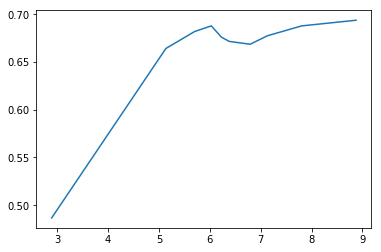

In [27]:
#def P6():
# Keep this random seed here to make comparison easier.
np.random.seed(0)

### STUDENT START ###
cv = CountVectorizer() # Instantiate count vectorizer
fv = cv.fit_transform(train_data) # create feature vector of the training data using fit_transform

lr1 = LogisticRegression(penalty='l1', tol=.01) # Instantiate a Logistic Regression classifier
lr1.fit(fv, train_labels) # Fit the Logistic Regression to the training data
print("Nonzero learned weights for L1 penalty {}".format(np.count_nonzero(lr1.coef_)))

lr2 = LogisticRegression(penalty='l2', tol=.01) # Instantiate a Logistic Regression classifier
lr2.fit(fv, train_labels) # Fit the Logistic Regression to the training data
print("Nonzero learned weights for L2 penalty {}".format(np.count_nonzero(lr2.coef_)))

Cs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2,10,100]
vocab_sizes = []
accuracys = []
for c in Cs:
    cv = CountVectorizer() # Instantiate count vectorizer
    fv = cv.fit_transform(train_data) # create feature vector of the training data using fit_transform
    
    lr1 = LogisticRegression(penalty='l1', tol=.01, C=c) # Instantiate a Logistic Regression classifier
    lr1.fit(fv, train_labels) # Fit the Logistic Regression to the training data    
    
    nz = np.nonzero(lr1.coef_[1:4])[1] # Select the location of the nonzero coefficients
    new_vocab = [cv.get_feature_names()[i] for i in nz] # For each nonzero coefficient grab the word to which it corresponds to create new vocabulary
    new_vocab = np.unique(new_vocab).tolist() # Remove duplicates and convert from array to list
    cv = CountVectorizer(vocabulary=new_vocab) # Instantiate count vectorizer with the new vocabulary
    nzfv = cv.fit_transform(train_data) # create feature vector of the training data using fit_transform
    vocab_sizes.append(nzfv.shape[1])
    nzdfv = cv.transform(dev_data) # create feature vector of the dev data using fit_transform
    
    lr2 = LogisticRegression(penalty='l2', tol=.01, C=c) # Instantiate a Logistic Regression classifier
    lr2.fit(nzfv, train_labels)
    pred = lr2.predict(nzdfv)
    accuracys.append(metrics.accuracy_score(dev_labels, pred))

plt.plot(np.log(vocab_sizes), accuracys)


### STUDENT END ###
#P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [28]:
#def P7():
### STUDENT START ###
tv = TfidfVectorizer() # Instantiate tf-idf vectorizer
fv = tv.fit_transform(train_data) # create feature vector of the training data using fit_transform
dv = tv.transform(dev_data) # create feature vector of the dev data using fit_transform
lr = LogisticRegression(penalty='l2', C=100) # Instantiate a Logistic Regression classifier
lr.fit(fv, train_labels) # Fit the Logistic Regression to the training data

pred = lr.predict(dv) # Predict the dev data 
pred_prob = lr.predict_proba(dv) # Record the probabilities of each class for each prediction
pred_prob_max = np.max(pred_prob,axis=1) # Record the maximum probability for each prediction

# Loop through the dev data finding the probability assigned to the correct label for each case
pred_prob_cor = []
for case in range(len(dev_labels)):
    label = dev_labels[case] # Find the label for each case
    pred_cor = pred_prob[case][label] # Find the predicted probability for the correct label
    pred_prob_cor.append(pred_cor) # Record this
pred_prob_cor = np.array(pred_prob_cor)


R = pred_prob_max / pred_prob_cor # Calculate R = maximum predicted probability / predicted probability of the correct label
R_max = np.argsort(R)[-3:] # Take the 3 largest values of R
R_max = np.flip(R_max,0) # Order them in descending order
for docloc in R_max:
    print(docloc)
    print("R: ",R[docloc])
    print("Predicted as {} {}".format(pred[docloc], newsgroups_train.target_names[pred[docloc]]))
    print("Correct class {} {}".format(dev_labels[docloc],newsgroups_train.target_names[dev_labels[docloc]]))
    print('\n')
    print(dev_data[docloc])
    print('________________________________________________________________________________')

# R = np.divide(pred_prob_max , pred_prob_cor)
# R
### STUDENT END ###
#P7()

215
R:  929.358342008191
Predicted as 1 comp.graphics
Correct class 3 talk.religion.misc


I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use o

ANSWER: 
* Tfidfvectorizer is different from countvectorizer in that countvectorizer weights all words equally. If a word is in the document, then the feature for that word receives a 1 for that document, otherwise it receives a 0. TF-IDF stands for Term Frequency and Inverse Document Frequency. Term Frequency counts the number of times a word appears in a document. Inverse Document Frequency takes the logarithm of the ratio of number of documents in corpus to number of documents in which the term appears. The closer this is to 1, the lower the weighting of the feature. The two, TF and IDF, are multiplied together and recorded in the feature space for a document. 

* It is interesting that these texts are either very short or very long. The document length may have suggest something is amiss. The model also seems to be making the mistake of overweighting words that "belong" to another class. For example, in the first two documents various computer-related terms appear such as "ftp" or "ASCII" or "RTF". The word "Mormon", which should indicate that this is more likely to be alt.atheism or talk.religion.misc, is receiving a lower weight than these tech terms becuase it occurs in more documents in the corpus. This is likely because two categories alt.atheism and talk.religion.misc may have many overlapping words. The tech terms by comparison may be more rare in the corpus so they receive a higher weight due to IDF. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [ ]:
# SCRATCH CODE

# nz = lr1.coef_ !=0
# nz = np.sum(nz, axis=0)
# nz = nz > 0
# np.outer(fv,nz)


# nz = nz[1:4]
# nz = np.unique(nz)
# print(nz.shape)
# nz = np.tile(nz, (2034, 1))
# print(nz.shape)

# pipe = Pipeline(steps=[
#                 ('countvectorizer',CountVectorizer()),
#                 ('lr1', LogisticRegression(penalty='l1',C=0.2)),
#                 ('lr2',LogisticRegression(penalty='l2',C=0.2, tol=.01))
#                       ])
# pipe.fit(train_data, train_labels)
# pred = pipe.predict(dev_data)
# metrics.accuracy_score(dev_labels, pred)
